In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Products URL should be considered "gold standard"
# strip leading/lagging whitespace
products_df = pd.read_csv('../data/products.csv')
for col_name in products_df.columns:
    stripped_col = products_df[col_name].str.strip().values
    products_df[col_name]  = stripped_col

products_df = products_df.drop_duplicates()
products_df.reset_index(drop=True, inplace=True)

product_categories_df = pd.read_csv('../data/product_categories.csv')
for col_name in product_categories_df.columns:
    stripped_col = product_categories_df[col_name].str.strip().values
    product_categories_df[col_name]  = stripped_col

log_df = pd.read_csv('../data/log2.csv',
                     names=['sentiment', 'publication_URL', 'product_URL',
                     'clickORnot', 'gender', 'age_group'])
for col_name in log_df.columns:
    if not col_name == 'clickORnot':
        stripped_col = log_df[col_name].str.strip().values
        log_df[col_name]  = stripped_col

In [5]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",   #REPLACE THIS WITH THE PASSWORD YOU SET
  database="data1050_project"
)
 
print(mydb)
 
if mydb.is_connected():
    print("CONNECTION SUCCESSFUL")

CONNECTION SUCCESSFUL


In [8]:
mycursor = mydb.cursor()
mycursor.execute("DROP TABLE products;")
mycursor.execute("DROP TABLE product_type_pubURLs;")
mycursor.execute("DROP TABLE product_categories;")


In [9]:
#create a table
mycursor.execute("CREATE TABLE product_categories (product VARCHAR(255), category VARCHAR(255),"
                 "PRIMARY KEY (product));")

mycursor.execute("CREATE TABLE products (product VARCHAR(255), product_URL VARCHAR(255), "
                 "product_type VARCHAR(255), PRIMARY KEY (product),"
                 "FOREIGN KEY (product_type) REFERENCES product_categories (product));")

In [10]:
for i,product_categories_row in product_categories_df.iterrows():
        sql = "INSERT INTO product_categories VALUES (%s,%s)"
        mycursor.execute(sql, tuple(product_categories_row))
        print("Record inserted")
        # the connection is not autocommitted by default, so we 
        # must commit to save our changes
        mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted


In [11]:
for i,products_row in products_df.iterrows():
        sql = "INSERT INTO products VALUES (%s,%s,%s)"
        mycursor.execute(sql, tuple(products_row))
        print("Record inserted")
        # the connection is not autocommitted by default, so we 
        # must commit to save our changes
        mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted


### Question 1
*Some of the Product_URLs in the log file might have been corrupted. Write a Python (or PySpark) procedure to determine which Product_URLs are corrupted. Let us assume that if a Product_url in the log file doesn’t occur in the products table, it is regarded as corrupted. Using this procedure identify and list the corrupted URLs. (10)*

The code below uses the simple list matching function `np.in1d()` to quickly identify which URLs in the log file are not present in hte products file.

In [12]:
product_urls = products_df['product_URL']
log_urls = log_df['product_URL']

# Check which elements of log_urls are NOT an exact match in product_urls
url_mask = ~np.in1d(log_urls, product_urls)
corrupt_df = log_df[url_mask]
corrupt_df

,sentiment,publication_URL,product_URL,clickORnot,gender,age_group
83,negative,https://www.cbsnews.com/,https://haier.com/refrigermtors,0,female,young
109,neutral,https://mashable.com/,https://sony.comftelevisions,1,female,juvenile
123,negative,https://www.thedailybeast.com/,https://lg.com/gashers,0,female,middle-age
171,neutral,https://www.cnn.com/,https://leks.com/jeans,0,female,senior
203,neutral,https://www.nytimes.com/,https://InstantPot.con/cookers,1,female,young
...,...,...,...,...,...,...
9729,neutral,https://www.usnews.com/,http://nejoK.co/blenders,0,male,senior
9773,negative,https://www.nbcnews.com/,https://maytag.cpm/washers,1,male,middle-age
9845,positive,https://www.foxnews.com/,https://guessmcom/perfumes,1,female,middle-age
9881,neutral,https://www.usnews.com/,https://samsuag.com/televisions,0,female,young


### Question 2
*For each corrupted URL what will you do with it? Don’t assume that for each corrupted URL the correct approach is to delete that log entry. What if the URL contained ‘.cam’ instead of ‘.com’ but otherwise corresponded with a URL in the ‘products’ table? In that case the proper approach would be to correct the URL. In other cases, the URL might be so corrupted that the best approach would be to delete that log entry (the entire row). Describe your approach to dealing with corrupted URLs. That is, describe your approach to determining that a URL is too corrupted to be rescued. It must describe a) a procedure for determining the degree to which the URL is corrupted, b) a threshold for determining in terms of this degree of corruption whether it can be corrected, and c) for those which can be corrected, identifying its corrected form. For extra credit implement this in a Python (or PySpark) program. (25 + 20 points for extra-credit)*

For the corrupted URLs, we are going to assume that there is one intended URL in 'products.csv'. To pair corrupted URLs to real URLs, we will utilize the "edit distance" to identify how many insertions, deletions, or character changes are necessary to transform a corrupted URL into one of the true URLs. Formally this is referred to a Levenshtein distance  

Assuming that it is unlikely that a single character is corrupted, I will set a edit distance threshold of 3 such that any URLs that are 3 edits or greater away from any of the ground truth URLs will be considered "too corrupted". Additionally, if any corrupted URLs have the same edit distance from 2 or more ground truth URLs they will not be included in the database.

In [13]:
# Utilizing natural language toolkit implementation: https://www.nltk.org/api/nltk.metrics.distance.html
from nltk.metrics.distance import edit_distance
from functools import partial

dist_dict = dict()
for true_url in product_urls:
    # Create function to calculate edit distance to true URL
    dist_func = partial(edit_distance, s2=true_url)
    dist_dict[true_url] = corrupt_df['product_URL'].map(dist_func)

dist_df = pd.DataFrame(dist_dict).set_index(corrupt_df['product_URL']).transpose()
dist_df
    

product_URL,https://haier.com/refrigermtors,https://sony.comftelevisions,https://lg.com/gashers,https://leks.com/jeans,https://InstantPot.con/cookers,https://lenova.comslaptops,https://broyhill.cvm/recliners,https://apple.cfm/ipads,https://soundwavemai/speakers,https://haieq.com/refrigerators,...,https://basilbasel.io/perfunes,https://cougar.co/jeaas,https://levia.com/jeans,https://Ikea.lom/sofas,https://apple.com/iqads,http://nejoK.co/blenders,https://maytag.cpm/washers,https://guessmcom/perfumes,https://samsuag.com/televisions,https://InstantPotycom/cookers
https://vitamix.com/blenders,16,16,12,13,14,14,13,14,16,16,...,17,14,12,14,13,9,12,15,15,14
https://lenova.com/laptops,16,14,10,10,16,1,17,12,17,16,...,18,13,9,12,12,12,12,14,14,16
https://InstantPot.com/cookers,19,19,14,16,1,16,16,16,16,19,...,18,16,15,14,15,15,13,18,18,1
http://nemoK.co/blenders,17,16,12,12,15,12,16,14,16,17,...,19,13,12,15,13,1,14,15,16,16
https://HamiltonBeach/blenders,19,19,16,18,18,17,17,16,16,19,...,17,18,18,19,16,12,16,20,19,18
https://Lavazza.com/coffee,17,19,13,13,14,14,16,13,18,17,...,16,14,11,11,12,16,13,14,17,14
https://Starbucks.com/coffee,19,20,15,13,14,17,17,15,20,19,...,17,15,15,14,14,18,15,14,18,14
https://centrum.com/vitamins,16,15,14,11,16,13,16,13,17,17,...,19,13,11,14,12,15,14,14,15,16
https://NordicTrack.com/treadmills,19,18,19,18,21,19,18,19,20,21,...,20,17,16,19,18,20,19,20,17,21
https://NordicTrack.com/rowers,18,18,15,16,15,17,16,17,18,19,...,18,15,14,15,16,18,15,18,19,15


In [14]:
dist_threshold = 3

# Make list of corrupted URLs that can be corrected
fixed_mask = list()
fixed_urls = list()
for col_idx in range(len(dist_df.columns)):
    url_distances = dist_df.iloc[:, col_idx]
    edit_counts = url_distances.value_counts()
    min_dist = edit_counts.min()

    if (min_dist > dist_threshold) or edit_counts[min_dist] > 1:
        fixed_mask.append(False)
    else:
        min_idx = np.where(url_distances.values == min_dist)
        assert len(min_idx) == 1
        
        fixed_mask.append(True)
        fixed_urls.append(product_urls[min_idx[0][0]])
        print(f'edit dist={min_dist}; {dist_df.columns[col_idx]}, {fixed_urls[-1]}')



edit dist=1; https://haier.com/refrigermtors, https://haier.com/refrigerators
edit dist=1; https://sony.comftelevisions, https://sony.com/televisions
edit dist=1; https://lg.com/gashers, https://lg.com/washers
edit dist=1; https://leks.com/jeans, https://lees.com/jeans
edit dist=1; https://InstantPot.con/cookers, https://InstantPot.com/cookers
edit dist=1; https://lenova.comslaptops, https://lenova.com/laptops
edit dist=1; https://broyhill.cvm/recliners, https://broyhill.com/recliners
edit dist=1; https://apple.cfm/ipads, https://apple.com/ipads
edit dist=1; https://soundwavemai/speakers, https://soundwave.ai/speakers
edit dist=1; https://haieq.com/refrigerators, https://haier.com/refrigerators
edit dist=1; https://reminxton.com/shavers, https://remington.com/shavers
edit dist=1; https://kaxi.com/handbags, https://kaai.com/handbags
edit dist=1; https://delk.com/computers, https://dell.com/computers
edit dist=1; https://apple.com/tomputers, https://apple.com/computers
edit dist=1; https

In [15]:
print(f'num corrupted: {len(corrupt_df)}; num recovered: {len(fixed_urls)}')

num corrupted: 216; num recovered: 216


As we can see above, our algorithm was able to identify a matching URL for every corrupted URL. Therefore we can simply substitute the "fixed" URLs into the 'product_URL' field of `log_df`

In [16]:
log_urls_fixed = log_df['product_URL'].values
log_urls_fixed[url_mask] = fixed_urls

# Store fixed URLs in new columns alongside boolean indicating which rows were fixed
log_df['product_URL'] = log_urls_fixed
log_df['url_fixed'] = url_mask

### Question 3
*For each product, compute all the Publication_URLs containing an ad for that product. (Don’t just give the results. Show all the work by which you got those results. This applies to all the questions below.) (10)*

To gather all the publication URLs, we need to combine information from `log2.csv` and `products.csv`. Since 'publication_URL' is present in both tables. To do this, we will first define a simple mapping function `get_pub_url()` that 1) looks up the product URL associated with a specific product name, and 2) use that product_URL to find and return all the publication URLs in the log file.

In [17]:
def get_pub_url(product_name, log_df=log_df, products_df=products_df):
    product_url = products_df.loc[products_df['product'] == product_name]['product_URL'].values
    assert len(product_url) == 1

    publication_URLs = log_df.loc[log_df['product_URL'] == product_url[0]]['publication_URL'].values
    publication_URLs = np.unique(publication_URLs)
    return publication_URLs


In [18]:
product_pub_urls = products_df['product'].map(get_pub_url)
product_pub_urls

0     [https://abcnews.go.com/, https://nypost.com/,...
1     [https://abcnews.go.com/, https://techcrunch.c...
2     [https://abcnews.go.com/, https://mashable.com...
3     [https://abcnews.go.com/, https://mashable.com...
4     [https://nypost.com/, https://techcrunch.com/,...
5     [https://nypost.com/, https://www.boston.com, ...
6     [https://mashable.com/, https://nypost.com/, h...
7     [https://mashable.com/, https://techcrunch.com...
8     [https://mashable.com/, https://techcrunch.com...
9     [https://abcnews.go.com/, https://mashable.com...
10    [https://nypost.com/, https://techcrunch.com/,...
11    [https://abcnews.go.com/, https://www.bbc.com/...
12    [https://mashable.com/, https://techcrunch.com...
13    [https://techcrunch.com/, https://www.boston.c...
14    [https://nypost.com/, https://www.al.com/, htt...
15    [https://mashable.com/, https://nypost.com/, h...
16    [https://mashable.com/, https://techcrunch.com...
17    [https://nypost.com/, https://time.com/, h

### Question 4
*For each product type, compute all the Publication_URLs containing an ad for that product type. Your solution must be scalable. That is, it should work well even if there are hundreds of products in each product_type and there are hundreds of product_types. (Hint: To make it scalable you should consider using a Python or PySpark script instead of a SQL query.) (20)*

In the previous question we calculated all the publication URLs for each product. Since a product type is associated

In [19]:
products_df['product_pub_URLs'] = product_pub_urls
type_pub_urls = products_df.groupby('product_type')['product_pub_URLs'].apply(list).apply(np.concatenate).apply(np.unique)

### Question 5
*Save this information in the database. Should you save it in the products table or the product_categories table or should you create a new table, product_type_pubURLs, and save this information in this table? If you create a new table, make sure to set up all the appropriate foreign
key constraints. On the other hand, if you use one of the existing tables, explain how you will avoid redundancy in your data. In either case, justify your decision. (10)*

product_type is a redundant entry in `products`, however we can add this information to the `product_categories` table since its primary key corresponds to the product type.


In [20]:
product_categories_pub_df = pd.merge(product_categories_df, type_pub_urls, left_on='product', right_on='product_type')

In [21]:
mycursor.execute("CREATE TABLE product_type_pubURLs (product_type VARCHAR(255), publication_URL VARCHAR(255),"
                 "PRIMARY KEY (product_type, publication_URL), FOREIGN KEY (product_type) REFERENCES product_categories (product));")

In [22]:
product_categories_pub_df
for i, product_categories_pub_row in product_categories_pub_df.iterrows():
    product_type, category, pub_list = product_categories_pub_row
    for pub_url in pub_list:
        sql = "INSERT INTO product_type_pubURLs VALUES (%s,%s)"
        mycursor.execute(sql, (product_type, pub_url))
        print("Record inserted")
        # the connection is not autocommitted by default, so we 
        # must commit to save our changes
        mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record i

### Question 6
*For each product, compute the click rate for it. (Click rate is the number of times a display of an ad was clicked on (by any user) divided by the number of times it was displayed (to any user). That is, the click rate is not specific to each user.) (10)*

In [23]:
log_product_df = pd.merge(log_df, products_df[['product', 'product_URL']],
                          left_on='product_URL', right_on='product_URL')

product_clickrate_groupby = log_product_df.groupby('product')['clickORnot']
product_clickrate = product_clickrate_groupby.sum() / product_clickrate_groupby.count()
product_clickrate.rename('clickrate', inplace=True)

product_clickrate

product
Apple computer                0.793103
Apple iPad                    0.503788
Apple laptop                  0.564516
BasilBasel perfume            0.649351
Broyhill recliner             0.539216
Centrum MultiVitamins         0.626556
Clinique moisturizer          0.805556
Coach purse                   0.388646
Cougar jeans                  0.260073
Covergirl makeup              0.252475
Dell computer                 0.651584
Dell laptop                   0.315186
Docker pants                  0.685897
Ford  sedan                   0.136564
Gillette shaver               0.713376
Giorgio perfume               0.799065
Givenchy perfume              0.459716
Guess perfume                 0.406977
Haier refrigerator            0.207547
Hamilton Beach blender        0.407767
Ikea sofa                     0.573034
InstantPot pressure cooker    0.500000
Jaguar perfume                0.473282
Kaai handbags                 0.660000
LG TV                         0.480769
LG dryer         

### Question 7
*For each product, compute the click rate for each sentiment type. (10)*


In [24]:
product_sentiment_groupby = log_product_df.groupby(['product', 'sentiment'])['clickORnot']
product_sentiment_clickrate = product_sentiment_groupby.sum() / product_sentiment_groupby.count()
product_sentiment_clickrate.rename('clickrate', inplace=True)

product_sentiment_clickrate

product             sentiment
Apple computer      negative     0.700000
                    neutral      0.923077
                    positive     0.764706
Apple iPad          negative     0.391304
                    neutral      0.627907
                                   ...   
bose speakers       neutral      0.463768
                    positive     0.523077
covergirl lipstick  negative     0.418605
                    neutral      1.000000
                    positive     1.000000
Name: clickrate, Length: 150, dtype: float64

### Question 8
*For each product type, compute the click rate for it. (10)*


In [25]:
log_product_type_df = pd.merge(log_product_df, products_df[['product', 'product_type']],
                               left_on='product', right_on='product')
                               
type_groupby = log_product_type_df.groupby('product_type')['clickORnot']

type_clickrate = type_groupby.sum() / type_groupby.count()
type_clickrate.rename('clickrate', inplace=True)

type_clickrate


product_type
blender               0.499237
car                   0.370450
coffee                0.355294
computer              0.558583
dryer                 0.452716
elliptical trainer    0.528409
face cream            0.805556
furniture             0.554974
jeans                 0.451477
lipstick              0.665698
makeup                0.252475
pants                 0.685897
perfume               0.566893
pressure cooker       0.500000
refrigerator          0.287273
rowing machine        0.223404
shaver                0.540000
speakers              0.535980
tablet                0.503788
television            0.533058
treadmill             0.489712
vitamin               0.626556
washer                0.518905
women's purse         0.515152
Name: clickrate, dtype: float64

### Question 9
*For each product type compute the click rate for each sentiment type. (10)*

In [26]:
type_sentiment_groupby = log_product_type_df.groupby(['product_type', 'sentiment'])['clickORnot']

type_sentiment_clickrate = type_sentiment_groupby.sum() / type_sentiment_groupby.count()
type_sentiment_clickrate.rename('clickrate', inplace=True)

type_sentiment_clickrate


product_type   sentiment
blender        negative     0.742739
               neutral      0.337963
               positive     0.378788
car            negative     0.391892
               neutral      0.581699
                              ...   
washer         neutral      0.518987
               positive     0.647482
women's purse  negative     0.386364
               neutral      0.694444
               positive     0.457516
Name: clickrate, Length: 72, dtype: float64

### Question 10
*Save this information you computed in 9 above in a database table. Should you save it in the products table or the product_categories table or the product_type_pubURLs table, or should you create a new table product_type_sentiment_clickrate, and save this information in this table? If you create a new table, make sure to set up all the appropriate foreign key constraints. On the other hand, if you use one of the existing tables, explain how you will avoid redundancy in your data. In either case, justify your decision. (10)*

In [35]:
type_sentiment_clickrate_df = type_sentiment_clickrate.unstack().reset_index(0)

product_categories_sentiment_df = pd.merge(product_categories_df, type_sentiment_clickrate_df,
                               left_on='product', right_on='product_type')

In [48]:
mycursor.execute("ALTER TABLE product_categories ADD negative FLOAT;")
mycursor.execute("ALTER TABLE product_categories ADD neutral FLOAT;")
mycursor.execute("ALTER TABLE product_categories ADD positive FLOAT;")

In [51]:
product_categories_pub_df
for i, product_sentiment_row in product_categories_sentiment_df.iterrows():
    product_type, _, _, negative, neutral, positive = product_sentiment_row

    sql = f"UPDATE product_categories SET negative={negative}, neutral={neutral}, positive={positive}"
    f"WHERE product={product_type};"
    
    mycursor.execute(sql)
    print("Record inserted")
    # the connection is not autocommitted by default, so we 
    # must commit to save our changes
    mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted


### Question 11
*Determine if the gender of the person viewing ads make a difference with regard to the click rate of ads shown in different sentiment context. That is, determine if there are any ‘significant’ differences in the correlation between the sentiment type of the ad context and clicking on the product type conditioned on gender. You can decide if any difference counts as ‘significant’. (This is not a yes or no question. Compute the different correlations.) (10)*

In [190]:
type_sentiment_gender_groupby = log_product_type_df.groupby(['product_type', 'sentiment', 'gender'])['clickORnot']

type_sentiment_gender_clickrate = type_sentiment_gender_groupby.sum() / type_sentiment_gender_groupby.count()
type_sentiment_gender_clickrate.rename('clickrate', inplace=True)
type_sentiment_gender_clickrate = type_sentiment_gender_clickrate.reset_index(0).reset_index(0).reset_index(0)
type_sentiment_gender_clickrate


,gender,sentiment,product_type,clickrate
0,female,negative,blender,0.695652
1,male,negative,blender,0.785714
2,female,neutral,blender,0.375000
3,male,neutral,blender,0.291667
4,female,positive,blender,0.377358
...,...,...,...,...
139,male,negative,women's purse,0.402985
140,female,neutral,women's purse,0.634921
141,male,neutral,women's purse,0.740741
142,female,positive,women's purse,0.462500


In [203]:
type_sentiment_gender_clickrate

,clickrate
clickrate,1.0


<AxesSubplot: xlabel='gender', ylabel='clickrate'>

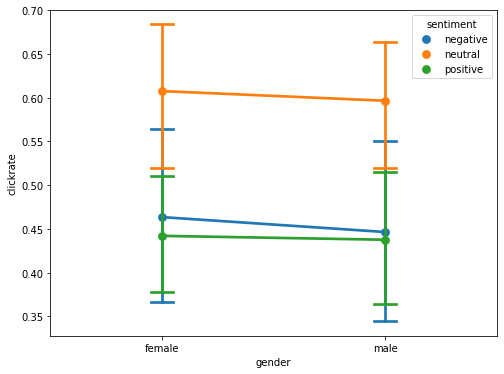

In [202]:
plt.figure(figsize=(8,6))
sns.pointplot(data=type_sentiment_gender_clickrate, y='clickrate', x='gender', hue='sentiment', capsize=0.1)

### Question 12 
*The same question as 9 above but replace gender with age-group. (10)*

In [183]:
type_sentiment_agegroup_groupby = log_product_type_df.groupby(['product_type', 'sentiment', 'age_group'])['clickORnot']

type_sentiment_agegroup_clickrate = type_sentiment_agegroup_groupby.sum() / type_sentiment_agegroup_groupby.count()
type_sentiment_agegroup_clickrate.rename('clickrate', inplace=True)

type_sentiment_agegroup_clickrate =  type_sentiment_agegroup_clickrate.reset_index(0).reset_index(0).reset_index(0)


In [184]:
type_sentiment_agegroup_clickrate

,age_group,sentiment,product_type,clickrate
0,juvenile,negative,blender,0.750000
1,middle-age,negative,blender,0.738462
2,senior,negative,blender,0.672727
3,young,negative,blender,0.803279
4,juvenile,neutral,blender,0.313725
...,...,...,...,...
283,young,neutral,women's purse,0.750000
284,juvenile,positive,women's purse,0.500000
285,middle-age,positive,women's purse,0.358974
286,senior,positive,women's purse,0.583333


<AxesSubplot: xlabel='age_group', ylabel='clickrate'>

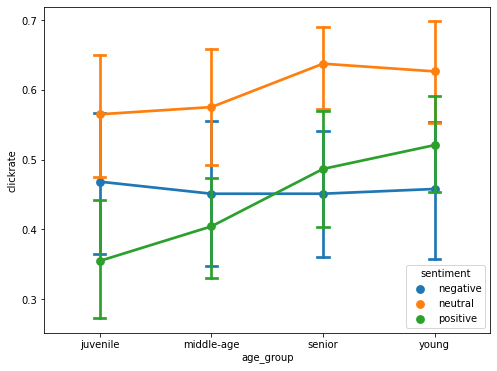

In [199]:
plt.figure(figsize=(8,6))
sns.pointplot(data=type_sentiment_agegroup_clickrate, y='clickrate', x='age_group', hue='sentiment', capsize=0.1)

### Question 13
*Based on your results make your recommendations. These should be in the form:
a. Based on our analysis (give details of your analysis), ads for such and such product are most likely to produce clicks in such and sentiment context (or state that we see no correlation between click rate of an ad for a product and the sentiment context of the ad)
b. Based on our analysis (with details), ads for such and such product are most likely to produce clicks in such and sentiment context by viewers of such and such gender (or state that we see no correlation between click rate of an ad for a product and the sentiment context of the ad and the gender of the viewer).
c. Based on our analysis (with details), ads for such and such product are most likely to produce clicks in such and sentiment context by viewers of such and such age-group (or state that we see no correlation between click rate of an ad for a product and the sentiment context of the ad and the age-group of the viewer). (15)*